# Greenspace metrics at multiple spatial scales from satellite images

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte

%matplotlib inline

In [2]:
#!pip install scikit-learn
#!pip install -U scikit-image

# 1. NDVI

## 1.1. NDVI input map

In [3]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [4]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [5]:
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [6]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

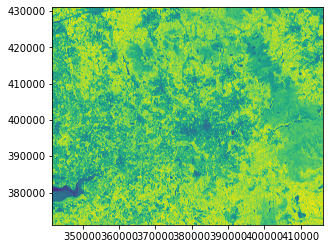

<AxesSubplot:>

In [7]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Focal statistics

### 1.2.1. Focal statistics at 100m

In [8]:
# design kernel at a 100m scale
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [9]:
# FFT convolve NDVI input with kernel at 100m (equivalent to average operation)
start_time = time.time()
ndvi_output_100_fft = fftconvolve(ndvi_input, ndvi_filter_100, mode = "same") / np.sum(ndvi_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100_fft.shape

--- 2.8151869773864746 seconds ---


(5987, 7443)

In [10]:
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.7670135498046875e-05 seconds ---


### 1.2.2. Focal statistics at 300m

In [11]:
# design kernel at a 300m scale
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [12]:
# FFT convolve NDVI input with kernel at 300m (equivalent to average operation)
start_time = time.time()
ndvi_output_300_fft = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300_fft.shape

--- 3.4105567932128906 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics at 500m

In [13]:
# design kernel at a 500m scale
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [14]:
# FFT convolve NDVI input with kernel at 500m (equivalent to average operation)
start_time = time.time()
ndvi_output_500_fft = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500_fft.shape

--- 2.9059810638427734 seconds ---


(5987, 7443)

## 1.3. NDVI output layer

### 1.3.1. NDVI output layer at 100m

In [15]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_100_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_100_fft.shape[0], width = ndvi_output_100_fft.shape[1],
                            count=1, dtype=str(ndvi_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100_fft, 1)
new_dataset.close()

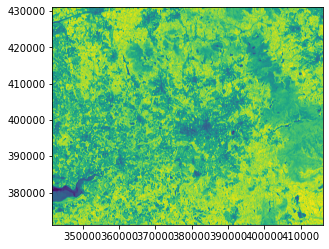

--- 2.406514883041382 seconds ---


In [16]:
# NDVI layer output at 100m
start_time = time.time()
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")
show(src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI output layer at 300m

In [18]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_300_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_300_fft.shape[0], width = ndvi_output_300_fft.shape[1],
                            count=1, dtype=str(ndvi_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300_fft, 1)
new_dataset.close()

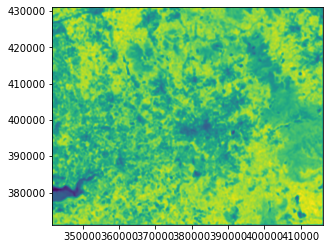

--- 2.352219820022583 seconds ---


In [19]:
# NDVI layer output at 300m
start_time = time.time()
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")
show(src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# check meta
src_300_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI output layer at 500m

In [21]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/ndvi_output_500_fft.tif', 'w', driver='GTiff',
                            height = ndvi_output_500_fft.shape[0], width = ndvi_output_500_fft.shape[1],
                            count=1, dtype=str(ndvi_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500_fft, 1)
new_dataset.close()

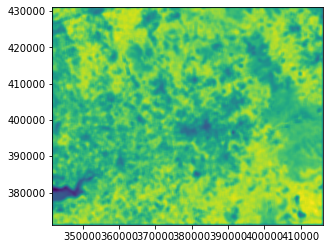

--- 2.6682159900665283 seconds ---


In [22]:
# NDVI layer output at 500m
start_time = time.time()
src_500_fft = rasterio.open("thesis_project/output/ndvi_output_500_fft.tif")
show(src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
# check crs
src_500_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

## 1.4. Generate random points within Greater Manchester Area

### 1.4.1. Generate random points at 100m from each other

In [133]:
# Greater Manchester Area bounds
#bounds = src_100_fft.bounds
#bounds
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.bounds

,minx,miny,maxx,maxy
0,351662.603729,381165.401794,406087.19669,421037.698468


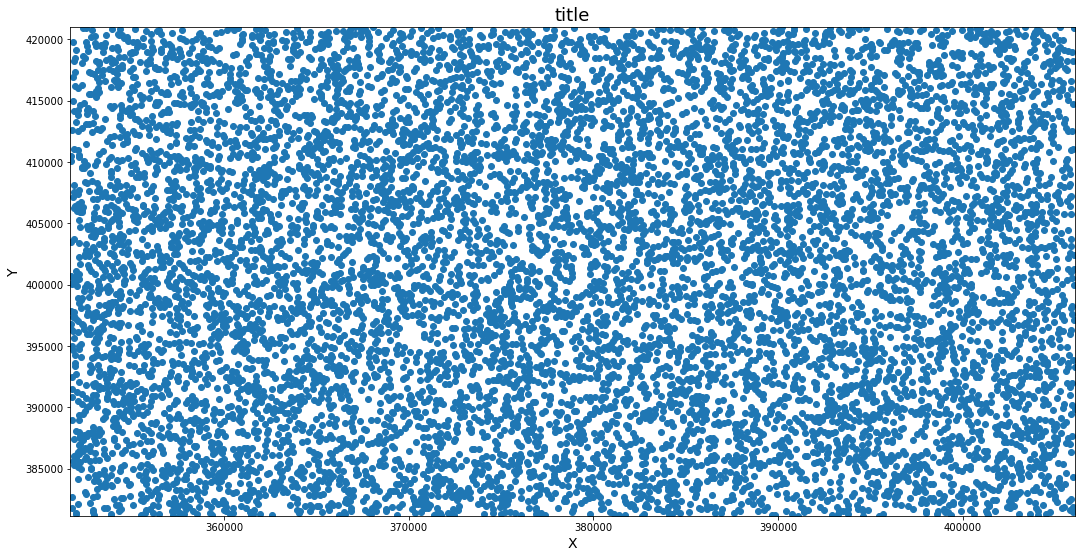

In [134]:
# generate random points at 100m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [135]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))
sample_100

0       POINT (353780.286 395706.974)
1       POINT (366247.996 408833.065)
2       POINT (403555.884 390283.490)
3       POINT (385813.833 395579.780)
4       POINT (364851.991 417160.478)
                    ...              
9995    POINT (374707.840 405934.320)
9996    POINT (399028.256 395244.451)
9997    POINT (393167.758 387356.435)
9998    POINT (375333.729 390920.655)
9999    POINT (374638.720 400802.306)
Length: 10000, dtype: geometry

In [136]:
# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (353780.286 395706.974)
1,POINT (366247.996 408833.065)
2,POINT (403555.884 390283.490)
3,POINT (385813.833 395579.780)
4,POINT (364851.991 417160.478)


In [137]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Generate random points at 300m from each other

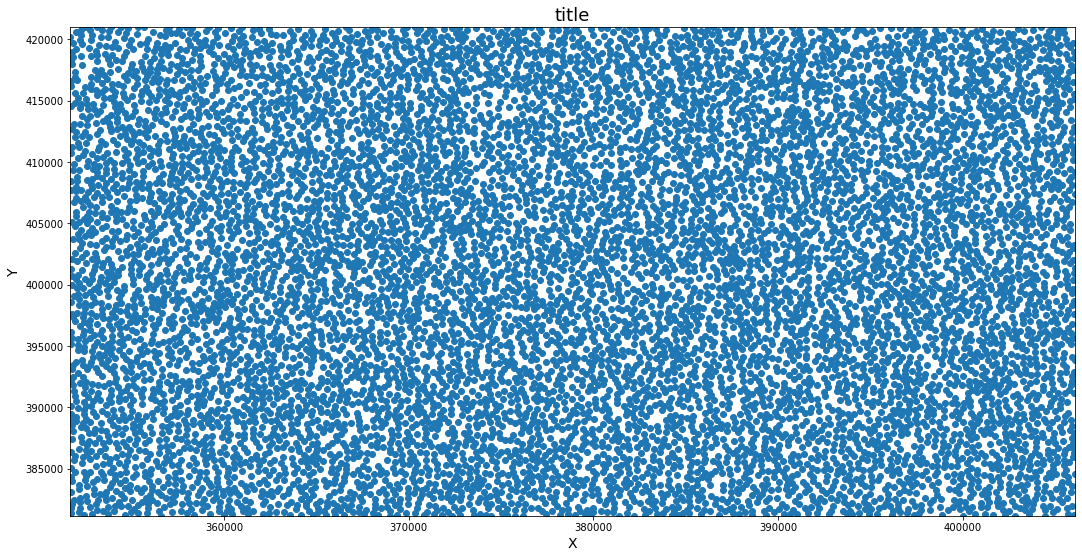

In [138]:
# generate random points at 300m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [140]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.3. Generate random points at 500m from each other

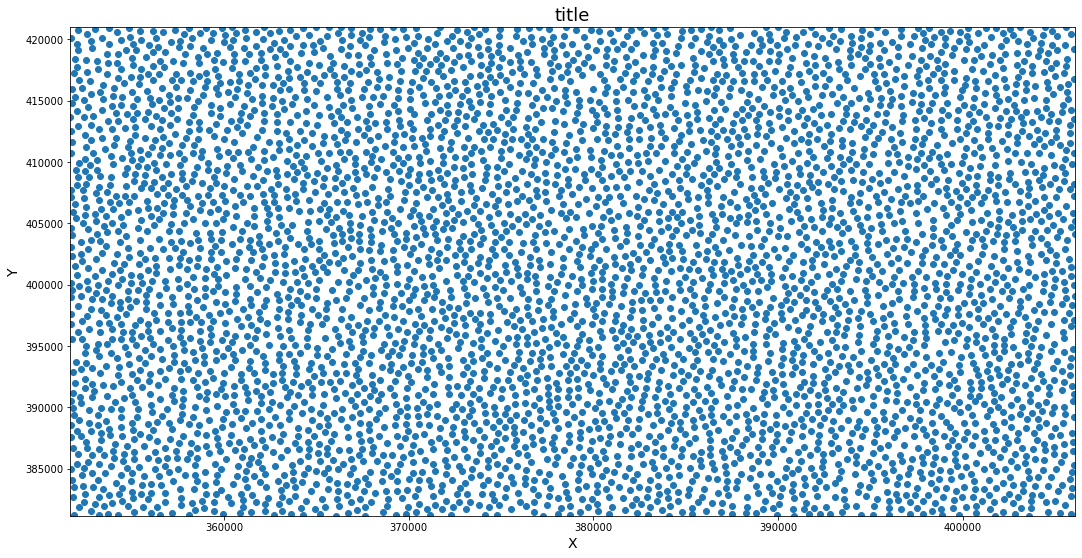

In [144]:
# generate random points at 500m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 5000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [145]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/sample_points_500.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 1.5. Extract raster values at point locations and store them into a Geodataframe

### 1.5.1. NDVI values at 100m

In [146]:
# read GeoJSON containing random points
gdf_100 = gpd.read_file("thesis_project/output/sample_points_100.json")
gdf_100.head()
#type(gdf_100)

,geometry
0,POINT (353780.286 395706.974)
1,POINT (366247.996 408833.065)
2,POINT (403555.884 390283.490)
3,POINT (385813.833 395579.780)
4,POINT (364851.991 417160.478)


In [147]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)"
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)"
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)"
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)"
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)"


In [148]:
# open the raster and store metadata
src_100_fft = rasterio.open("thesis_project/output/ndvi_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in src_100_fft.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)",0.552929
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)",0.458902
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)",0.555790
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)",0.347293
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)",0.390930


In [38]:
# type of dataframe
type(gdf_100)

geopandas.geodataframe.GeoDataFrame

### 1.5.2. NDVI values at 300m

In [149]:
# read GeoJSON containing random points
gdf_300 = gpd.read_file("thesis_project/output/sample_points_300.json")
gdf_300.head()
#type(gdf_100)

,geometry
0,POINT (384713.357 394255.209)
1,POINT (387034.589 396075.398)
2,POINT (395300.134 404726.178)
3,POINT (366481.480 381239.565)
4,POINT (392473.837 382347.228)


In [150]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)"
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)"
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)"
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)"
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)"


In [151]:
# open the raster and store metadata
src_300_fft = rasterio.open("thesis_project/output/ndvi_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in src_300_fft.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",0.378221
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",0.226592
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",0.361229
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",0.520634
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",0.658977


### 1.5.3. NDVI values at 500m

In [152]:
# read GeoJSON containing random points
gdf_500 = gpd.read_file("thesis_project/output/sample_points_500.json")
gdf_500.head()
#type(gdf_500)

,geometry
0,POINT (372673.972 394848.116)
1,POINT (383073.527 408838.647)
2,POINT (401805.027 388146.712)
3,POINT (372549.883 390299.040)
4,POINT (372644.583 414079.514)


In [153]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)"
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)"
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)"
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)"
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)"


In [154]:
# open the raster and store metadata
src_500 = rasterio.open("thesis_project/output/ndvi_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)",0.392228
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)",0.483724
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)",0.718238
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)",0.464561
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)",0.542579


# 2. Greenspace%

## 2.1. Greenspace% input map

In [45]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [46]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [47]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

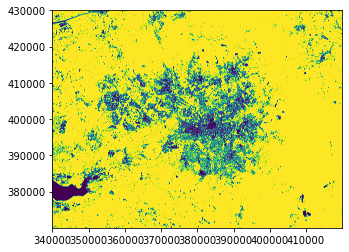

<AxesSubplot:>

In [48]:
# plot input % Greenness
show(green_input_raster, 1)

## 2.2. Focal statistics

### 2.2.1. Focal statistics at 100m

In [49]:
# design kernel at a 100m scale
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [50]:
# FFT convolve Green No Green input with kernel at 100m (r = 41)
start_time = time.time()
green_output_100_fft = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100_fft.shape

--- 25.953856945037842 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics at 300m

In [51]:
# design kernel at a 300m scale
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [52]:
# FFT convolve Green No Green input with kernel at 300m (r = 121)
start_time = time.time()
green_output_300_fft = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300_fft.shape

--- 22.86153793334961 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics at 500m

In [53]:
# design kernel at a 500m scale
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [54]:
# FFT convolve Green No Green input with kernel at 500m (r = 201)
start_time = time.time()
green_output_500_fft = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500_fft.shape

--- 23.411490201950073 seconds ---


(12000, 16000)

## 2.3. Greenspace% output layer

In [55]:
# % greenness input map bounds
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [56]:
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Greenspace% output layer at 100m

In [57]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_100_fft.tif', 'w', driver='GTiff',
                            height = green_output_100_fft.shape[0], width = green_output_100_fft.shape[1],
                            count=1, dtype=str(green_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100_fft, 1)
new_dataset.close()

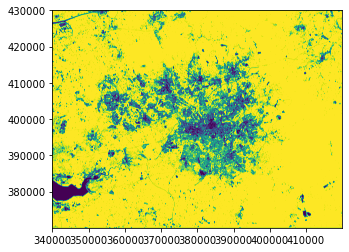

--- 17.302156925201416 seconds ---


In [58]:
# % greenness layer output at 100m
start_time = time.time()
src_100_fft = rasterio.open("thesis_project/output/greenspace_output_100_fft.tif")
show(src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [59]:
# output layer metadata
src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Greenspace% output layer at 300m

In [60]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_300_fft.tif', 'w', driver='GTiff',
                            height = green_output_300_fft.shape[0], width = green_output_300_fft.shape[1],
                            count=1, dtype=str(green_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300_fft, 1)
new_dataset.close()

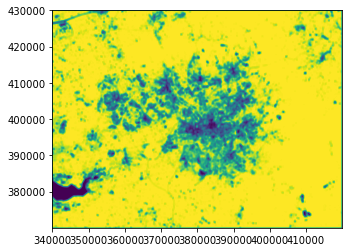

--- 14.826843023300171 seconds ---


In [61]:
# % greenness layer output at 300m
start_time = time.time()
src_300_fft = rasterio.open("thesis_project/output/greenspace_output_300_fft.tif")
show(src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [62]:
# output layer metadata
src_300_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.3. Greenspace% output layer at 500m

In [63]:
# convert % greenness output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/greenspace_output_500_fft.tif', 'w', driver='GTiff',
                            height = green_output_500_fft.shape[0], width = green_output_500_fft.shape[1],
                            count=1, dtype=str(green_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500_fft, 1)
new_dataset.close()

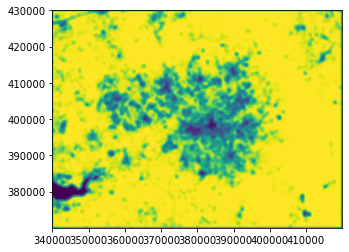

--- 14.90994381904602 seconds ---


In [64]:
# % greenness layer output at 500m
start_time = time.time()
src_500_fft = rasterio.open("thesis_project/output/greenspace_output_500_fft.tif")
show(src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [65]:
# output layer metadata
src_500_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

## 2.4. Extract raster values at point locations and store them into a Geodataframe

### 2.4.1. Greenspace% values at 100m

In [155]:
# open the raster and store metadata
green_src_100 = rasterio.open("thesis_project/output/greenspace_output_100_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_100['Greenspace%_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)",0.552929,0.992861
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)",0.458902,0.601428
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)",0.555790,1.000000
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)",0.347293,0.465199
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)",0.390930,1.000000


In [67]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

### 2.4.2. Greenspace% values at 300m

In [156]:
# open the raster and store metadata
green_src_300 = rasterio.open("thesis_project/output/greenspace_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_300['Greenspace%_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",0.378221,0.530292
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",0.226592,0.295198
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",0.361229,0.464449
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",0.520634,0.999454
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",0.658977,0.999180


In [69]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

### 2.4.3. Greenspace% values at 500m

In [157]:
# open the raster and store metadata
green_src_500 = rasterio.open("thesis_project/output/greenspace_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
gdf_500['Greenspace%_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)",0.392228,0.517017
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)",0.483724,0.663746
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)",0.718238,0.999455
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)",0.464561,0.971783
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)",0.542579,0.835326


In [71]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

# 3. Canopy%

## 3.1. Canopy% input map

In [72]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_trees_2m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [73]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

In [74]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [75]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

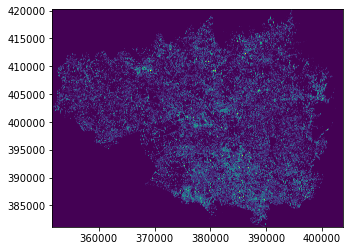

<AxesSubplot:>

In [76]:
# plot Tree No Trees input map
show(tree_input_raster, 1)

## 3.2. Focal statistics

### 3.2.1. Focal statistics at 100m

In [77]:
# design kernel at a 100m scale
tree_filter_100 = np.ones((101, 101))
tree_filter_100.shape

(101, 101)

In [78]:
# FFT convolve Tree No Trees input with kernel at 100m (r = 101)
start_time = time.time()
tree_output_100_fft = fftconvolve(tree_input, tree_filter_100, mode = "same") / np.sum(tree_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_100_fft.shape

--- 165.730947971344 seconds ---


(19520, 26119)

### 3.2.2. Focal statistics at 300m

In [79]:
# design kernel at a 300m scale
tree_filter_300 = np.ones((301, 301))
tree_filter_300.shape

(301, 301)

In [80]:
# FFT convolve Tree No Trees input with kernel at 300m (r = 301)
start_time = time.time()
tree_output_300_fft = fftconvolve(tree_input, tree_filter_300, mode = "same") / np.sum(tree_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_300_fft.shape

--- 239.98694396018982 seconds ---


(19520, 26119)

### 3.2.3. Focal statistics at 500m

In [81]:
# design kernel at a 500m scale
tree_filter_500 = np.ones((501, 501))
tree_filter_500.shape

(501, 501)

In [82]:
# FFT convolve Tree No Trees input with kernel at 500m (r = 501)
start_time = time.time()
tree_output_500_fft = fftconvolve(tree_input, tree_filter_500, mode = "same") / np.sum(tree_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
tree_output_500_fft.shape

--- 269.3195860385895 seconds ---


(19520, 26119)

## 3.3. Canopy% output layer

In [83]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

### 3.3.1. Canopy% output layer at 100m

In [84]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_100_fft.tif', 'w', driver='GTiff',
                            height = tree_output_100_fft.shape[0], width = tree_output_100_fft.shape[1],
                            count=1, dtype=str(tree_output_100_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_100_fft, 1)
new_dataset.close()

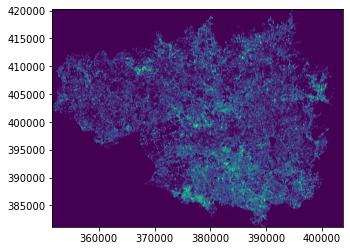

--- 43.410417795181274 seconds ---


In [85]:
# Tree no Trees output layer at 100m
start_time = time.time()
tree_src_100_fft = rasterio.open("thesis_project/output/canopy_output_100_fft.tif")
show(tree_src_100_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [86]:
# output layer metadata
tree_src_100_fft.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

### 3.3.2. Canopy% output layer at 300m

In [87]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_300_fft.tif', 'w', driver='GTiff',
                            height = tree_output_300_fft.shape[0], width = tree_output_300_fft.shape[1],
                            count=1, dtype=str(tree_output_300_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_300_fft, 1)
new_dataset.close()

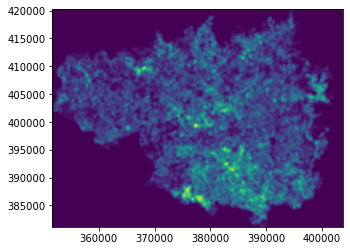

--- 43.76258993148804 seconds ---


In [88]:
# Tree no Trees output layer at 300m
start_time = time.time()
tree_src_300_fft = rasterio.open("thesis_project/output/canopy_output_300_fft.tif")
show(tree_src_300_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

### 3.3.3. Canopy% output layer at 500m

In [89]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/canopy_output_500_fft.tif', 'w', driver='GTiff',
                            height = tree_output_500_fft.shape[0], width = tree_output_500_fft.shape[1],
                            count=1, dtype=str(tree_output_500_fft.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(tree_output_500_fft, 1)
new_dataset.close()

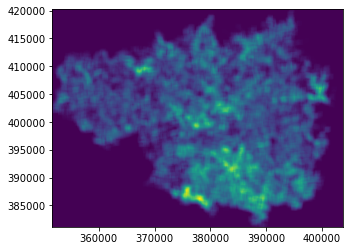

--- 71.61647391319275 seconds ---


In [90]:
# Tree no Trees output layer at 500m
start_time = time.time()
tree_src_500_fft = rasterio.open("thesis_project/output/canopy_output_500_fft.tif")
show(tree_src_500_fft, 1)
print("--- %s seconds ---" % (time.time() - start_time))

## 3.4. Extract raster values at point locations and store them into a Geodataframe

### 3.4.1. Canopy% values at 100m

In [158]:
# open the raster and store metadata
tree_src_100 = rasterio.open("thesis_project/output/canopy_output_100_fft.tif")
tree_src_100.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

In [159]:
# check gdf
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)",0.552929,0.992861
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)",0.458902,0.601428
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)",0.555790,1.000000
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)",0.347293,0.465199
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)",0.390930,1.000000


In [160]:
# create polygon with tree raster bounds
polygon = Polygon([(351667.1259, 381167.084), (351667.1259, 420207.084), (403905.1259, 420207.084), (403905.1259, 381167.084)])


In [161]:
# keep list of points within tree raster bounds
tree_100_points = []
for p in gdf_100.geometry:
    if polygon.contains(p):
        tree_100_points.append(p)
        
len(tree_100_points) #4954 points within tree raster extent
#tree_100_points

9441

In [162]:
# create gdf including points within tree raster bounds
tree_df_100 = pd.DataFrame(tree_100_points, columns=['geometry'])
tree_gdf_100 = gpd.GeoDataFrame(tree_df_100, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_100.head()


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (353780.286 395706.974)
1,POINT (366247.996 408833.065)
2,POINT (403555.884 390283.490)
3,POINT (385813.833 395579.780)
4,POINT (364851.991 417160.478)


In [163]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_100['point_coordinates'] = point_coords
tree_gdf_100.head()

,geometry,point_coordinates
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)"
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)"
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)"
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)"
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)"


In [164]:
# sample the raster at every point location and store values in Geodataframe
tree_gdf_100['Canopy%_100'] = [x[0] for x in tree_src_100.sample(tree_gdf_100.point_coordinates)]
tree_gdf_100.head()

,geometry,point_coordinates,Canopy%_100
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)",0.000000e+00
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)",9.910793e-02
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)",-4.054003e-17
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)",2.525243e-01
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)",5.515755e-17


In [165]:
# keep geometry and Canopy%_100
tree_gdf_100 = tree_gdf_100[['geometry', 'Canopy%_100']]
tree_gdf_100.head()

,geometry,Canopy%_100
0,POINT (353780.286 395706.974),0.000000e+00
1,POINT (366247.996 408833.065),9.910793e-02
2,POINT (403555.884 390283.490),-4.054003e-17
3,POINT (385813.833 395579.780),2.525243e-01
4,POINT (364851.991 417160.478),5.515755e-17


In [99]:
# check gdf with other greenspace metrics
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (401190.382 427948.310),"(401190.38169709296, 427948.30953670637)",0.460991,1.000000
1,POINT (345455.896 396163.607),"(345455.8960522365, 396163.60738968494)",0.671017,1.000000
2,POINT (409607.755 380632.575),"(409607.7545708217, 380632.57537936483)",0.795668,1.000000
3,POINT (353907.507 380264.970),"(353907.50706834666, 380264.96990331006)",0.583563,0.997620
4,POINT (382918.378 408417.323),"(382918.3782770588, 408417.3228268393)",0.381966,0.430101


In [166]:
# merge gdf with tree gdf on geometry using left operation
gdf_100_complete = pd.merge(gdf_100, tree_gdf_100, on='geometry', how='left')
gdf_100_complete.head()


,geometry,point_coordinates,NDVI_100,Greenspace%_100,Canopy%_100
0,POINT (353780.286 395706.974),"(353780.28581793344, 395706.9738067279)",0.552929,0.992861,0.000000e+00
1,POINT (366247.996 408833.065),"(366247.9962505436, 408833.06513272197)",0.458902,0.601428,9.910793e-02
2,POINT (403555.884 390283.490),"(403555.8835582526, 390283.48977829015)",0.555790,1.000000,-4.054003e-17
3,POINT (385813.833 395579.780),"(385813.8330783914, 395579.77990839886)",0.347293,0.465199,2.525243e-01
4,POINT (364851.991 417160.478),"(364851.9914810463, 417160.4775672112)",0.390930,1.000000,5.515755e-17


In [167]:
# check if nulls
gdf_100_complete.isnull().values.any()

True

In [168]:
# take rows where 'Canopy%_100' is not NaN
gdf_100 = gdf_100_complete[gdf_100_complete['Canopy%_100'].notna()]
len(gdf_100)

9441

In [169]:
# keep target columns
gdf_100 = gdf_100[['geometry', 'NDVI_100', 'Greenspace%_100', 'Canopy%_100']]
gdf_100.head()

,geometry,NDVI_100,Greenspace%_100,Canopy%_100
0,POINT (353780.286 395706.974),0.552929,0.992861,0.000000e+00
1,POINT (366247.996 408833.065),0.458902,0.601428,9.910793e-02
2,POINT (403555.884 390283.490),0.555790,1.000000,-4.054003e-17
3,POINT (385813.833 395579.780),0.347293,0.465199,2.525243e-01
4,POINT (364851.991 417160.478),0.390930,1.000000,5.515755e-17


In [170]:
# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_100','Greenspace%_100', 'Canopy%_100']
gdf_100[cols_to_norm] = gdf_100[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_100.head()

,geometry,NDVI_100,Greenspace%_100,Canopy%_100
0,POINT (353780.286 395706.974),0.701978,0.992861,2.968764e-16
1,POINT (366247.996 408833.065),0.604345,0.601428,1.881630e-01
2,POINT (403555.884 390283.490),0.704949,1.000000,2.199084e-16
3,POINT (385813.833 395579.780),0.488456,0.465199,4.794342e-01
4,POINT (364851.991 417160.478),0.533766,1.000000,4.015967e-16


In [171]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/greenspace_metrics_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 3.4.2. Canopy% values at 300m

In [172]:
# check gdf
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",0.378221,0.530292
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",0.226592,0.295198
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",0.361229,0.464449
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",0.520634,0.999454
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",0.658977,0.999180


In [173]:
# keep list of points within tree raster bounds
tree_300_points = []
for p in gdf_300.geometry:
    if polygon.contains(p):
        tree_300_points.append(p)
        
len(tree_300_points)
#tree_300_points

9377

In [174]:
# create gdf including points within tree raster bounds
tree_df_300 = pd.DataFrame(tree_300_points, columns=['geometry'])
tree_gdf_300 = gpd.GeoDataFrame(tree_df_300, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_300.head()

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (384713.357 394255.209)
1,POINT (387034.589 396075.398)
2,POINT (395300.134 404726.178)
3,POINT (366481.480 381239.565)
4,POINT (392473.837 382347.228)


In [176]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_300['point_coordinates'] = point_coords
tree_gdf_300.head()

,geometry,point_coordinates
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)"
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)"
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)"
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)"
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)"


In [177]:
# open the raster and store metadata
tree_src_300 = rasterio.open("thesis_project/output/canopy_output_300_fft.tif")

# sample the raster at every point location and store values in Geodataframe
tree_gdf_300['Canopy%_300'] = [x[0] for x in tree_src_300.sample(tree_gdf_300.point_coordinates)]
tree_gdf_300.head()

,geometry,point_coordinates,Canopy%_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",1.717089e-01
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",9.616892e-02
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",1.801415e-01
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",9.005655e-18
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",1.344381e-17


In [178]:
# keep target columns
tree_gdf_300 = tree_gdf_300[['geometry', 'Canopy%_300']]
tree_gdf_300.head()

,geometry,Canopy%_300
0,POINT (384713.357 394255.209),1.717089e-01
1,POINT (387034.589 396075.398),9.616892e-02
2,POINT (395300.134 404726.178),1.801415e-01
3,POINT (366481.480 381239.565),9.005655e-18
4,POINT (392473.837 382347.228),1.344381e-17


In [179]:
# check gdf with other greenspace metrics
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",0.378221,0.530292
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",0.226592,0.295198
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",0.361229,0.464449
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",0.520634,0.999454
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",0.658977,0.999180


In [180]:
# merge gdf with tree gdf on geometry using left operation
gdf_300_complete = pd.merge(gdf_300, tree_gdf_300, on='geometry', how='left')
gdf_300_complete.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,Canopy%_300
0,POINT (384713.357 394255.209),"(384713.35680395726, 394255.2089671792)",0.378221,0.530292,1.717089e-01
1,POINT (387034.589 396075.398),"(387034.5889060649, 396075.39751223277)",0.226592,0.295198,9.616892e-02
2,POINT (395300.134 404726.178),"(395300.13449450786, 404726.17750642373)",0.361229,0.464449,1.801415e-01
3,POINT (366481.480 381239.565),"(366481.4800891847, 381239.56500744575)",0.520634,0.999454,9.005655e-18
4,POINT (392473.837 382347.228),"(392473.83711906936, 382347.22848568426)",0.658977,0.999180,1.344381e-17


In [181]:
# check if nulls
gdf_300_complete.isnull().values.any()

True

In [182]:
# take rows where 'Canopy%_300' is not NaN
gdf_300 = gdf_300_complete[gdf_300_complete['Canopy%_300'].notna()]
len(gdf_300) == len(tree_300_points)

True

In [183]:
# keep target columns
gdf_300 = gdf_300[['geometry', 'NDVI_300', 'Greenspace%_300', 'Canopy%_300']]
gdf_300.head()

,geometry,NDVI_300,Greenspace%_300,Canopy%_300
0,POINT (384713.357 394255.209),0.378221,0.530292,1.717089e-01
1,POINT (387034.589 396075.398),0.226592,0.295198,9.616892e-02
2,POINT (395300.134 404726.178),0.361229,0.464449,1.801415e-01
3,POINT (366481.480 381239.565),0.520634,0.999454,9.005655e-18
4,POINT (392473.837 382347.228),0.658977,0.999180,1.344381e-17


In [184]:
# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_300','Greenspace%_300', 'Canopy%_300']
gdf_300[cols_to_norm] = gdf_300[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_300.head()

,geometry,NDVI_300,Greenspace%_300,Canopy%_300
0,POINT (384713.357 394255.209),0.485173,0.528844,4.424253e-01
1,POINT (387034.589 396075.398),0.285426,0.293025,2.477889e-01
2,POINT (395300.134 404726.178),0.462789,0.462798,4.641527e-01
3,POINT (366481.480 381239.565),0.672780,0.999452,4.089324e-16
4,POINT (392473.837 382347.228),0.855025,0.999178,4.203677e-16


In [185]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/greenspace_metrics_300.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 3.4.3. Canopy% values at 500m

In [119]:
# check gdf
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (361752.508 427403.487),"(361752.5075183512, 427403.4870884819)",0.724705,0.998663
1,POINT (383941.057 387127.338),"(383941.056703843, 387127.3379269903)",0.508747,0.743298
2,POINT (401495.548 417310.502),"(401495.54774875345, 417310.5015586266)",0.428476,0.998416
3,POINT (380062.471 416123.268),"(380062.47061798215, 416123.2675862869)",0.603313,0.896339
4,POINT (405080.132 412192.763),"(405080.1323945999, 412192.7627812388)",0.546209,0.995495


In [186]:
# keep list of points within tree raster bounds
tree_500_points = []
for p in gdf_500.geometry:
    if polygon.contains(p):
        tree_500_points.append(p)
        
len(tree_500_points)
#tree_500_points

4675

In [187]:
# create gdf including points within tree raster bounds
tree_df_500 = pd.DataFrame(tree_500_points, columns=['geometry'])
tree_gdf_500 = gpd.GeoDataFrame(tree_df_500, geometry='geometry', crs = 'epsg:27700')                   
tree_gdf_500.head()

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (372673.972 394848.116)
1,POINT (383073.527 408838.647)
2,POINT (401805.027 388146.712)
3,POINT (372549.883 390299.040)
4,POINT (372644.583 414079.514)


In [188]:
# obtain point coordinates (x, y) from point geometry (x y) to later sample raster values
point_coords = []
for index, row in tree_gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
tree_gdf_500['point_coordinates'] = point_coords
tree_gdf_500.head()

,geometry,point_coordinates
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)"
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)"
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)"
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)"
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)"


In [189]:
# open the raster and store metadata
tree_src_500 = rasterio.open("thesis_project/output/canopy_output_500_fft.tif")

# sample the raster at every point location and store values in Geodataframe
tree_gdf_500['Canopy%_500'] = [x[0] for x in tree_src_500.sample(tree_gdf_500.point_coordinates)]
tree_gdf_500.head()

,geometry,point_coordinates,Canopy%_500
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)",1.153262e-01
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)",6.162525e-02
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)",-8.005497e-18
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)",5.579261e-02
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)",1.002147e-01


In [190]:
# keep target columns
tree_gdf_500 = tree_gdf_500[['geometry', 'Canopy%_500']]
tree_gdf_500.head()

,geometry,Canopy%_500
0,POINT (372673.972 394848.116),1.153262e-01
1,POINT (383073.527 408838.647),6.162525e-02
2,POINT (401805.027 388146.712),-8.005497e-18
3,POINT (372549.883 390299.040),5.579261e-02
4,POINT (372644.583 414079.514),1.002147e-01


In [125]:
# check gdf with other greenspace metrics
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (361752.508 427403.487),"(361752.5075183512, 427403.4870884819)",0.724705,0.998663
1,POINT (383941.057 387127.338),"(383941.056703843, 387127.3379269903)",0.508747,0.743298
2,POINT (401495.548 417310.502),"(401495.54774875345, 417310.5015586266)",0.428476,0.998416
3,POINT (380062.471 416123.268),"(380062.47061798215, 416123.2675862869)",0.603313,0.896339
4,POINT (405080.132 412192.763),"(405080.1323945999, 412192.7627812388)",0.546209,0.995495


In [191]:
# merge gdf with tree gdf on geometry using left operation
gdf_500_complete = pd.merge(gdf_500, tree_gdf_500, on='geometry', how='left')
gdf_500_complete.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,Canopy%_500
0,POINT (372673.972 394848.116),"(372673.9722012084, 394848.1159477914)",0.392228,0.517017,1.153262e-01
1,POINT (383073.527 408838.647),"(383073.5274197485, 408838.64731007814)",0.483724,0.663746,6.162525e-02
2,POINT (401805.027 388146.712),"(401805.02689413057, 388146.71203175304)",0.718238,0.999455,-8.005497e-18
3,POINT (372549.883 390299.040),"(372549.8828883642, 390299.04012949654)",0.464561,0.971783,5.579261e-02
4,POINT (372644.583 414079.514),"(372644.58262711373, 414079.5143935795)",0.542579,0.835326,1.002147e-01


In [192]:
# check if nulls
gdf_500_complete.isnull().values.any()

True

In [193]:
# take rows where 'Canopy%_500' is not NaN
gdf_500 = gdf_500_complete[gdf_500_complete['Canopy%_500'].notna()]
len(gdf_500) == len(tree_500_points)

True

In [195]:
# keep target columns
gdf_500 = gdf_500[['geometry', 'NDVI_500', 'Greenspace%_500', 'Canopy%_500']]
gdf_500.head()

,geometry,NDVI_500,Greenspace%_500,Canopy%_500
0,POINT (372673.972 394848.116),0.392228,0.517017,1.153262e-01
1,POINT (383073.527 408838.647),0.483724,0.663746,6.162525e-02
2,POINT (401805.027 388146.712),0.718238,0.999455,-8.005497e-18
3,POINT (372549.883 390299.040),0.464561,0.971783,5.579261e-02
4,POINT (372644.583 414079.514),0.542579,0.835326,1.002147e-01


In [196]:
# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_500','Greenspace%_500', 'Canopy%_500']
gdf_500[cols_to_norm] = gdf_500[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_500.head()

,geometry,NDVI_500,Greenspace%_500,Canopy%_500
0,POINT (372673.972 394848.116),0.502140,0.485566,3.393393e-01
1,POINT (383073.527 408838.647),0.634665,0.641850,1.813280e-01
2,POINT (401805.027 388146.712),0.974342,0.999420,3.009884e-16
3,POINT (372549.883 390299.040),0.606910,0.969945,1.641658e-01
4,POINT (372644.583 414079.514),0.719913,0.824603,2.948748e-01


In [197]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/greenspace_metrics_500.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
